# Inference

#### SpecAugment

In [1]:
import datasets
from transformers import WhisperForConditionalGeneration, WhisperProcessor
import torch
from jiwer import wer
import soundfile as sf
from IPython.display import Audio
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

In [2]:
dataset = datasets.load_from_disk("/scratch/s5754798/wtimit_loaded")['test']

In [3]:
def filter_normal(example):
    return example['audio']['path'].split('.')[0].endswith('n')

In [4]:
def filter_us(example):
    return int(example['audio']['path'].split('.')[0].split('u')[0].split('s')[1]) >= 101

In [5]:
normal = dataset.filter(filter_normal)
whispering = dataset.filter(lambda example: not filter_normal(example))

In [6]:
normal_us = normal.filter(lambda example: filter_us(example))
normal_sg = normal.filter(lambda example: not filter_us(example))

In [7]:
whisper_us = whispering.filter(lambda example: filter_us(example))
whisper_sg = whispering.filter(lambda example: not filter_us(example))

## Check split correctness

In [8]:
def play(index, mode):
    audio_array = mode[index]['audio']['array']
    sample_rate = mode[index]['audio']['sampling_rate']

    print(mode[index]['text'])
    return Audio(audio_array, rate=sample_rate)

In [9]:
play(345, whisper_us)

A toothpaste tube should be squeezed from the bottom.


## Model load

In [17]:
PATH = '/scratch/s5754798/EXPERIMENTS/ft-augmented-sa'
CHECKPOINT = 800

In [18]:
MODEL = "{}/checkpoint-{}".format(PATH, CHECKPOINT)

In [19]:
processor = WhisperProcessor.from_pretrained(MODEL)
model = WhisperForConditionalGeneration.from_pretrained(MODEL).to("cuda")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [20]:
from functools import partial
model.generate = partial(model.generate, language="english", task="transcribe")

In [21]:
from whisper_normalizer.english import EnglishTextNormalizer
normalizer = EnglishTextNormalizer()

In [22]:
def map_to_pred(batch):
    audio = batch["audio"]
    input_features = processor(audio["array"], sampling_rate=audio["sampling_rate"], return_tensors="pt").input_features
    batch["reference"] = processor.tokenizer._normalize(batch['text'])

    with torch.no_grad():
        predicted_ids = model.generate(input_features.to("cuda"))[0]
    transcription = processor.decode(predicted_ids,)
    batch["prediction"] = processor.tokenizer._normalize(transcription)
    return batch

## Evaluation

### Normal Mode

In [23]:
result_normal_us = normal_us.map(map_to_pred)
result_normal_sg = normal_sg.map(map_to_pred)

Map:   0%|          | 0/633 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

### Whisper Mode

In [24]:
result_whisper_us = whisper_us.map(map_to_pred)
result_whisper_sg = whisper_sg.map(map_to_pred)

Map:   0%|          | 0/625 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

### Result

In [27]:
df = pd.DataFrame({
    'N_us': [wer(result_normal_us["reference"], result_normal_us["prediction"])],
    'N_sg': [wer(result_normal_sg["reference"], result_normal_sg["prediction"])],
    'W_us': [wer(result_whisper_us["reference"], result_whisper_us["prediction"])],
    'W_sg': [wer(result_whisper_sg["reference"], result_whisper_sg["prediction"])]
})

In [28]:
df.style.hide()

N_us,N_sg,W_us,W_sg
0.054440,0.120536,0.115357,0.235045


## Plots

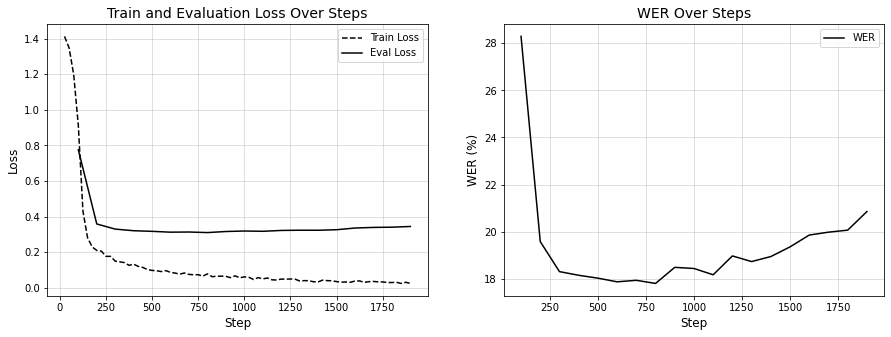

In [29]:
import json
import os
import matplotlib.pyplot as plt

def load_metrics_from_checkpoint(checkpoint_dir):
    training_state_path = os.path.join(checkpoint_dir, 'trainer_state.json')
    with open(training_state_path, 'r') as file:
        state = json.load(file)
    return state['log_history']

checkpoint_dirs = ["{}/checkpoint-{}".format(PATH, i) for i in range(100, 2000, 100)]

all_metrics = []
for checkpoint in checkpoint_dirs:
    metrics = load_metrics_from_checkpoint(checkpoint)
    all_metrics.extend(metrics)

all_metrics_sorted = sorted(all_metrics, key=lambda x: x['step'])

steps = [entry['step'] for entry in all_metrics_sorted if 'loss' in entry]
losses = [entry['loss'] for entry in all_metrics_sorted if 'loss' in entry]
val_steps = [entry['step'] for entry in all_metrics_sorted if 'eval_loss' in entry]
val_losses = [entry['eval_loss'] for entry in all_metrics_sorted if 'eval_loss' in entry]
wer_steps = [entry['step'] for entry in all_metrics_sorted if 'eval_wer' in entry]
wer_scores = [entry['eval_wer'] for entry in all_metrics_sorted if 'eval_wer' in entry]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(steps, losses, label='Train Loss', linestyle='--', color='black')
axes[0].plot(val_steps, val_losses, label='Eval Loss', linestyle='-', color='black')
axes[0].set_xlabel('Step', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Train and Evaluation Loss Over Steps', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.5)

axes[1].plot(wer_steps, wer_scores, label='WER', color='black')
axes[1].set_xlabel('Step', fontsize=12)
axes[1].set_ylabel('WER (%)', fontsize=12)
axes[1].set_title('WER Over Steps', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.5)